# US Gap Analysis Project - WV Breeding Bird Atlas Data Comparison

*Nathan Tarr and Jessie Jordan*

## Cover type associations in West Virginia Summarized Across All Species

We investigated the agreement between WV Breeding Bird Atlas (2011-2015) and USGS Gap Analysis Project data

In [33]:
import pandas as pd
import numpy as np
import repo_functions as fun
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 15)

In [34]:
# Call species lists and generate empty dataframes-----------------------------
specieslist = (pd.read_csv(fun.dataDir + "/SpeciesLists/WV_GAP_Atlas.csv", 
                           index_col ='strCommonName', header=0))
mastdf = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["Species", "detections"])
masteval = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                              "Additions"], columns=["Species", 
                                            "GAP_types"])
allunmatch = []

# Load land cover crosswalk - slow loading for some reason
cross = pd.read_csv(fun.dataDir + "LandCover/land_cover_crosswalk.csv", 
                    header=0, dtype={'GAP_code': str}) 


In [35]:
for species in specieslist.index[0:10] :
    try:
        # Perform crosswalk of detections from WV -> USGAP
        master, GAP_linked, unmatched, gap_types, wv_types = fun.cross_to_GAP(species, 
                                                    cross, print_tables=True)
        
        #print(str("Species summary complete for ") + species)
        master_valid = master[master['evaluation'] == 'valid']
        master_add = master[master['evaluation'] == 'add_association']
        usable_df = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["detections"])
        usable_df.loc['Supported validation', 
                      'detections'] = int(master_valid[['detections']].sum())
        usable_df.loc['Supported addition', 
                      'detections'] = int(master_add[['detections']].sum())
        usable_df.loc['Total detections', 
                      'detections'] = wv_types['detections'].sum()
        usable_df.loc['Unusable', 
                      'detections'] = int(wv_types['detections'].sum() - 
                                          master_valid[['detections']].sum() - 
                                          master_add[['detections']].sum())
        usable_df.insert(0, "Species", species, True)
        usable_df = usable_df.fillna(0)
        mastdf = pd.concat([usable_df, mastdf])
        
        # Aggregate results for proportion of GAP systems validated------------
        eval_df = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                                      "Additions"], columns=["GAP_types"])
        eval_df.loc['Unvalidated', "GAP_types"] = len(gap_types) - len(master_valid)
        eval_df.loc['Validated', "GAP_types"] = len(master_valid)
        eval_df.loc['Additions', "GAP_types"] = len(master_add)
        eval_df.insert(0, "Species", species, True)
        eval_df = eval_df.fillna(0)
        masteval = pd.concat([eval_df, masteval])
        print(usable_df)
        print(eval_df)
        print(unmatched)
        print(species + " add successful")
        #Generate a full list of unmatched habitat types across all species
        allunmatch.append(unmatched)
    except Exception as e: 
            print(str("Concatonate failed for ") + species)  



System associations in the GAP model
Empty DataFrame
Columns: [GAP_name]
Index: []

WVBBA detections by WVBBA habitat type
                wv_name_fine detections
wv_code_fine                           
16a               Old fields          3
16c           Abandoned mine          3
17a                  Pasture          4
17b                      Hay          3
0 of 0 GAP ecological system associations were validated.
                               Species  detections
Unusable              American Kestrel        27.0
Supported validation  American Kestrel         0.0
Supported addition    American Kestrel         6.0
Total detections      American Kestrel        33.0
                      Species  GAP_types
Unvalidated  American Kestrel          0
Validated    American Kestrel          0
Additions    American Kestrel          2
{'17': 20.0}
American Kestrel add successful

System associations in the GAP model
Empty DataFrame
Columns: [GAP_name]
Index: []
Concatonate failed for Bewick'

5 of 33 GAP ecological system associations were validated.
                                  Species  detections
Unusable              Common Yellowthroat       306.0
Supported validation  Common Yellowthroat        74.0
Supported addition    Common Yellowthroat        13.0
Total detections      Common Yellowthroat       393.0
                         Species  GAP_types
Unvalidated  Common Yellowthroat         28
Validated    Common Yellowthroat          5
Additions    Common Yellowthroat          2
{'17': 31.0, '4a': 1.0, '8a': 1.0, '32': 2.0}
Common Yellowthroat add successful

System associations in the GAP model
Empty DataFrame
Columns: [GAP_name]
Index: []

WVBBA detections by WVBBA habitat type
             wv_name_fine detections
wv_code_fine                        
15b                 River          1
17b                   Hay          1
0 of 0 GAP ecological system associations were validated.
                                       Species  detections
Unusable              Dou

In [5]:
df = pd.DataFrame(allunmatch)
df2=pd.DataFrame.transpose(df)
sumdf = df.sum(axis=1)
avgun = sumdf.mean(axis=0)
df2['Unmatched Observations'] = df2.sum(axis=1)
df2['Number of spp with Record'] = df2.count(axis=1)
print(df2[['Unmatched Observations', 'Number of spp with Record']])
unobvs = df2['Unmatched Observations'].sum(axis=0)

print("Average number of unusable records per species due to incorrect data entry: " + str(avgun))
print("Total Unmatched observations due to incorrect code entry: " + str(unobvs)) 


    Unmatched Observations  Number of spp with Record
17                   108.0                          6
3a                     3.0                          3
32                    47.0                          3
4a                     1.0                          2
8a                     1.0                          2
Average number of unusable records per species due to incorrect data entry: 22.857142857142858
Total Unmatched observations due to incorrect code entry: 160.0


In [6]:
#Clean up master tables to create pivot tables
mastdf = mastdf.dropna()
masteval = masteval.dropna()
masteval = masteval.astype({'GAP_types': 'int32'})

#Create pivot table summarizing the validity of WVBBA habitat detections
pivdf = mastdf.pivot_table(index = mastdf.index,
                           aggfunc = {'detections' : [ np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
pivdf.rename(columns={"detections" : "Species-Habitat Detections", 
                      "mean" : "Average", "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True) 

                     Species-Habitat Detections                  
                                          Count     Average Total
Supported addition                            6    7.428571    52
Supported validation                          4   23.714286   166
Total detections                              6  169.000000  1183
Unusable                                      6  137.857143   965


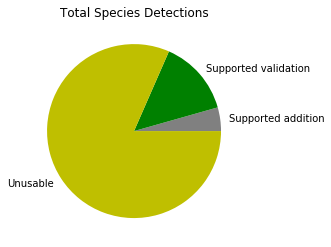

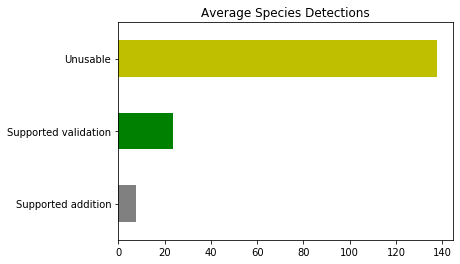

In [7]:
#Display Table and plot pie chart of total detections
print(pivdf)
plt1 = pivdf.drop(['Total detections']).plot(y=('Species-Habitat Detections',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total Species Detections",
                                             colors=['gray', 'g', 'y'])
plt1.set_ylabel("")
plt2 = pivdf.drop(['Total detections']).plot.barh(x= None, y=('Species-Habitat Detections',        'Average'), 
                                                  color=['gray', 'g', 'y'], legend=False, title = "Average Species Detections")   

In [8]:
#Create pivot table summarizing the proportion of GAP systems validated 
piveval = masteval.pivot_table(index = masteval.index,
                           aggfunc = {'GAP_types' : [np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
piveval.rename(columns={"GAP_types" : "GAP Systems Validated by WVBBA", "mean" : "Average", 
                        "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True)

            GAP Systems Validated by WVBBA                 
                                     Count    Average Total
Additions                                2   1.428571    10
Unvalidated                              4  12.571429    88
Validated                                4   1.285714     9


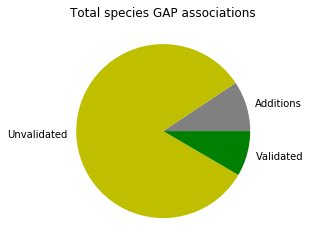

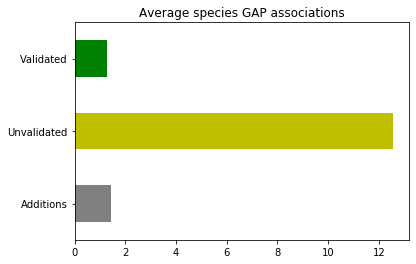

In [9]:
#Display data table and plot tables of the sum of validated GAP associations and the average per species
print(piveval)
plt3 = piveval.plot(y=('GAP Systems Validated by WVBBA',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total species GAP associations",
                                             colors=['gray', 'y', 'g'])
plt3.set_ylabel("")
plt4 = piveval.plot.barh(x = None, y=('GAP Systems Validated by WVBBA',        'Average'), 
                         color=['gray', 'y', 'g'],
                         legend=False, title = "Average species GAP associations") 

In [19]:
#This is a test block
result_sp, GAP_linked, sp_unmatched, GAP_types, WVBBA_types = fun.cross_to_GAP(species, 
                                                    cross, print_tables=False)

0 of 0 GAP ecological system associations were validated.


In [20]:
print(result_sp)

  GAP_code  GAP_associated  cross_confidence  cross_matches  detections wv_code_fine                               wv_name_fine  link_strength                              GAP_name support evaluation
0     8203             0.0               1.0            2.0         2.0            9  Successional or plantation conifer forest            0.5               Managed Tree Plantation     med        NaN
1     8202             0.0               1.0            2.0         2.0            9  Successional or plantation conifer forest            0.5  Evergreen Plantation or Managed Pine     med        NaN


In [32]:
print(master['evaluation'])

0    NaN
1    NaN
Name: evaluation, dtype: object
